# Guided Upsampling with Guided Image Filtering

### In this tutorial you will 

 - #### implement guided image filtering, described in the paper http://kaiminghe.com/publications/pami12guidedfilter.pdf
 - #### use your guided image filtering implementation for guided image upsampling

##### Let's recall what is guided image filtering.

Let $I, p\in \mathbb{R}^{H\times W}$ be some $\textit{grayscaled}$ images. The output of guided image filtering with parameters
- window radius = $r$
- epsilon = $\varepsilon$

is also an image of the same size - $q\in \mathbb{R}^{H\times W}$, which is given by the following formula

$$
q_i = \overline{a}_i \cdot I_i + \overline{b}_i, \quad \mbox{for each image pixel    } i\in \{1,2,\ldots,H\cdot W\}
$$

where 

$$
\overline{a}_i = \frac{1}{|\omega_i|}\sum_{k\in \omega_i}a_k, \quad
\overline{b}_i = \frac{1}{|\omega_i|}\sum_{k\in \omega_i}b_k,
$$

$$
a_k = \frac{\frac{1}{|\omega_k|}\sum_{j\in \omega_k}I_j p_j - \mu_k \overline{p}_k}{\sigma^2_k + \varepsilon},\qquad
b_k = \overline{p}_k - a_k\mu_k
$$
and
$$
\omega_k \; \mbox{is the window of radius }\; r \; \mbox{ centered in the pixel } \; k \; \mbox{ for each } \; k\in \{1,2,\ldots,H\cdot W\},
$$

$$
\mu_k \; \mbox{and} \; \sigma_k \; \mbox{are the mean and standard deviation of the image} \; I \; \mbox{in the window} \; \omega_k \; \mbox{respectively},
$$

$$
\overline{p}_k \; \mbox{is the mean of the image} \; p \; \mbox{in the window} \; \omega_k.
$$

#### We refer to the images $p, q$ and $I$ as $input, output$ and $guidance$ images respectively.

Let's try to implement guided image filtering function.

In [0]:
from skimage.io import imread, imsave
from skimage.transform import resize
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from glob import glob
from time import time
import os

In [0]:
def guided_filter(I, p, radius = 3, eps = 1e-6):
    k_size = radius*2 + 1 # TODO Obtain the kernel_size for "average blur" convolution
    kernel = np.ones((k_size, k_size)) / (k_size ** 2) # TODO Obtain the kernel for "average blur" convolution
    
    # np.mean(np.dot(I, p)) - np.mean(I) - np.mean(p)
    E_I_p = convolve2d(I * p, kernel[::-1,::-1], mode = 'same')
    E_I = convolve2d(I, kernel[::-1,::-1], mode = 'same')
    E_p = convolve2d(p, kernel[::-1,::-1], mode = 'same')
    cov = E_I_p - E_I * E_p # TODO Obtain the covariance of the images I and p in the window \omega. Recall that cov(X,Y) = E(XY)-E(X)E(Y)
    
    E_II = convolve2d(I ** 2, kernel[::-1,::-1], mode = 'same')
    var = E_II - E_I ** 2 # TODO Obtain the variance of the image I in the window \omega. Recall that var(X) = cov(X,X) = E(X^2)-(E(X))^2
    
    # Computing the image a
    a = cov / (var + eps)
    
    # Computing the image b
    b = E_p - a*E_I
    
    a_ = convolve2d(a, kernel[::-1,::-1], mode = 'same') # TODO Compute the image a_
    b_ = convolve2d(b, kernel[::-1,::-1], mode = 'same') # TODO Compute the image b_
    
    # Computing the output image q
    q = a_ * I + b_
    
    # Let's return a_, b_, and q
    return a_, b_, q

### Now we have done with guided image filtering function! Let's apply it to the upsampling task.

Let we have an image of high resolution and some "filtered" version of it in low resolution. Our goal is to obtain the "filtered" version of the initial image in high resolution.

### Here we assume we have $3-channeled$ images !!!

For this let's first denote by $I_H, O_L$ and $O_H$ the high resolution input, low resolution output of "filter" and desired high resolution output of "filter" respectively. So we need to obtain $O_H$ from $I_H$ and $O_L$. For this we do the following steps:
- resize the image $I_H$ to the size of $O_L$,
- apply per-channel guided filtering with some (default) parameters $r$ and $\varepsilon$,
- bilinearly resize obtained images $a$ and $b$ (per-channel) to the size of the image $I_H$,
- compute with the resized coefficients the linear combination of the initial high resolution image $I_H$ and $1$.

In [0]:
def guided_upsampling(I_H, O_L):
    I_res = resize(I_H, O_L.shape) # TODO Resize the image I_H to the size of O_L
    O_H = []
    # Append per-channel outputs to the list O_H
    for i in range(3):
        a_, b_, q = guided_filter(I_res[:, :, i], O_L[:, :, i])
        a_ = resize(a_, I_H[:, :, i].shape)
        b_ = resize(b_, I_H[:, :, i].shape)
        q = a_ * I_H[:, :, i] + b_
        # TOD_O obtain for each channel i guided filter coefficients a_ and b_
        # TODO resize the 1-channeled coefficient-images a_ and b_ to the size I_H
        # TODO obtain the resulting 1-channel image q
        
        O_H.append(q)
        
    return np.stack(O_H, axis = -1)

### Now let's explore our data by visualizing some points from it.

In [0]:
data_dir = 'guided_up_project_data/'
paths_highres = glob(os.path.join(data_dir, 'inp_highres', '*'))
'out_lowres'

'out_lowres'

(1366, 1024) (342, 256)
(1024, 1280) (256, 320)
(1024, 1396) (256, 349)
(1024, 1820) (256, 455)
(1024, 1536) (256, 384)


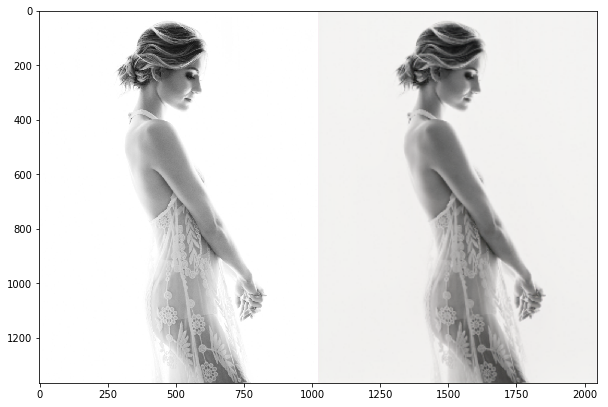

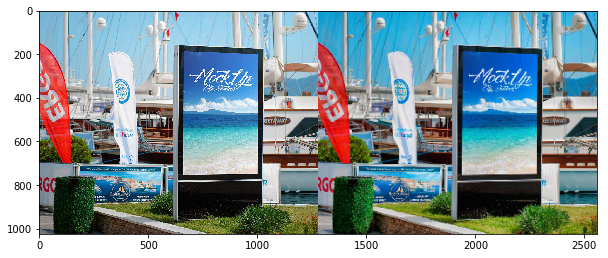

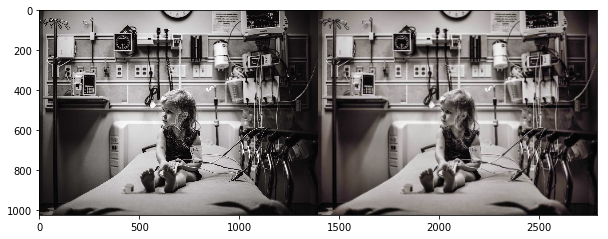

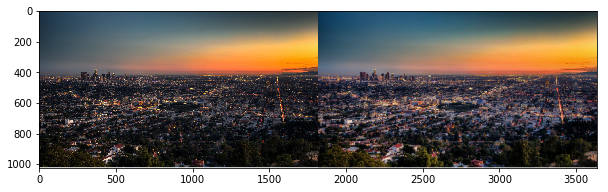

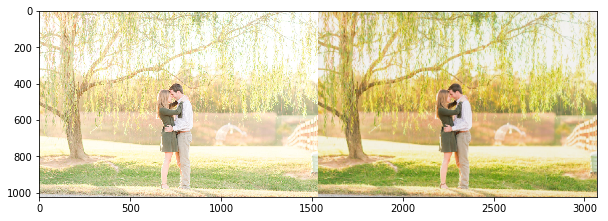

In [0]:
for i in range(5):
    path_highres = paths_highres[i]
    path_lowres = path_highres.replace('inp_highres', 'out_lowres')
    im_h = imread(path_highres)/255.
    im_l = imread(path_lowres)/255.
    
    print(im_h.shape[:2], im_l.shape[:2])
    plt.figure(figsize = (10,12))
    plt.imshow(np.hstack([im_h, resize(im_l, im_h.shape[:2])]))

### As you can notice the low resolution output is a "color adjusted" version of the high resolution input, but is blury.

Now let us apply guided upsampling and save the results to the 'out_highres' subdirectory in our data

In [0]:
for i in range(len(paths_highres)):
    path_highres = paths_highres[i]
    path_lowres = path_highres.replace('inp_highres', 'out_lowres')
    name = os.path.basename(path_highres)
    im_h = imread(path_highres)/255.
    im_l = imread(path_lowres)/255.
    
    start = time()
    result = guided_upsampling(im_h, im_l)
    dur = time() - start
    
    stacked = np.hstack([im_h, result, resize(im_l, im_h.shape[:2])])
    
    print('duration of guided upsampling of an image with size '+ str(im_h.shape[:2]) +' was '+ str(dur))
    imsave(os.path.join(data_dir, 'results', name), stacked)

duration of guided upsampling of an image with size (1366, 1024) was 2.0345535278320312


Lossy conversion from float64 to uint8. Range [-0.012629058402531083, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1280) was 1.9009044170379639


Lossy conversion from float64 to uint8. Range [-0.5428901981590062, 1.530252016644818]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.22465893452935723, 1.3776291842482482]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1396) was 2.0250701904296875
duration of guided upsampling of an image with size (1024, 1820) was 2.6029932498931885


Lossy conversion from float64 to uint8. Range [-0.1097817663464156, 1.8259231348187035]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1536) was 2.2524802684783936


Lossy conversion from float64 to uint8. Range [-0.525115013472003, 1.104222354567514]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1408) was 1.8685381412506104


Lossy conversion from float64 to uint8. Range [-0.42795959636340547, 1.2819183350749204]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1535) was 2.0287203788757324


Lossy conversion from float64 to uint8. Range [-0.0804975887710569, 1.5876515374241458]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2081892214986162, 1.2762626524102116]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1024) was 1.4706840515136719


Lossy conversion from float64 to uint8. Range [-0.22312224599201594, 1.5574921900831602]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1436) was 2.016282796859741
duration of guided upsampling of an image with size (1024, 1820) was 2.566535472869873


Lossy conversion from float64 to uint8. Range [-0.3499485180175117, 1.8238455614657427]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1365) was 2.2961387634277344


Lossy conversion from float64 to uint8. Range [-0.04905893312210037, 0.7482009535579424]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1536) was 2.7713069915771484


Lossy conversion from float64 to uint8. Range [-0.018956920512379755, 1.3394473917306746]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1535) was 2.6228408813476562


Lossy conversion from float64 to uint8. Range [-0.03382407432341298, 0.9595226319266512]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.7383580598597673, 1.3484644306422071]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1251) was 1.811790943145752
duration of guided upsampling of an image with size (1024, 1539) was 2.0377533435821533


Lossy conversion from float64 to uint8. Range [-0.07530087829827004, 1.0608966591539173]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1638) was 3.073301315307617


Lossy conversion from float64 to uint8. Range [-0.15776901012758993, 1.3686384931479705]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1365) was 2.0561439990997314


Lossy conversion from float64 to uint8. Range [0.006593161925521063, 1.0383329009649775]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1533) was 2.39095139503479


Lossy conversion from float64 to uint8. Range [-0.23627013776058992, 1.3870194122748323]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.11275209756941078, 1.241119152417067]. Convert image to uint8 prior to saving to suppress this warning.


duration of guided upsampling of an image with size (1024, 1365) was 2.2874109745025635
